In [1]:
# Import necessary libraries
from gw_grb_correlation.Fermi import download_and_preprocess_fermi_data
from gw_grb_correlation.Fermi.visualization import plot_all_detector_positions, create_time_data_plots, create_location_data_plots
from gw_grb_correlation.Fermi.util import duration, filtering, read_GW_data, remove_duplicate_times_in_gw_data, compare_time_within_range

In [2]:
# Download and preprocess Fermi data
start_year = 2015
end_year = 2026
fermi_data = download_and_preprocess_fermi_data(start_year=start_year, end_year=end_year, download_or_not=False)


Preprocessed data saved to ./fermi_data/fermi/

Preprocessed data saved to ./fermi_data/fermi/


<Figure size 1000x600 with 0 Axes>

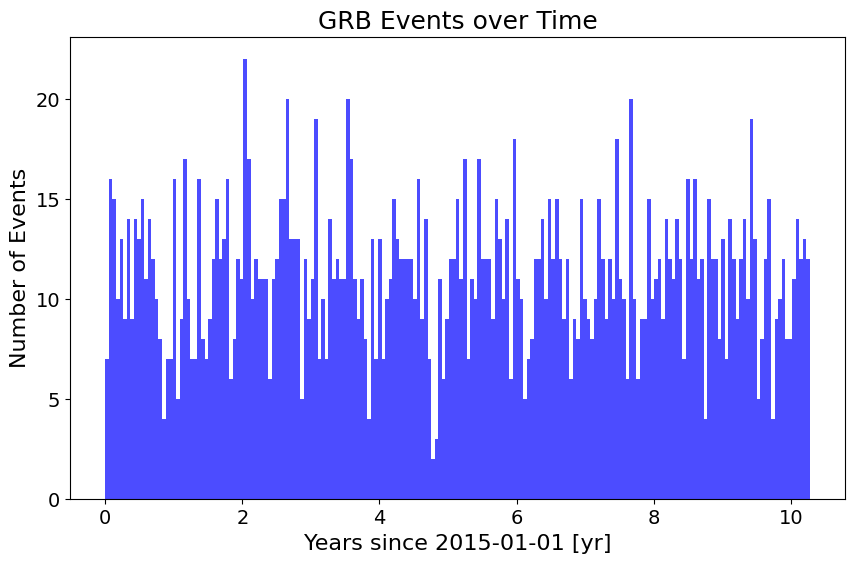

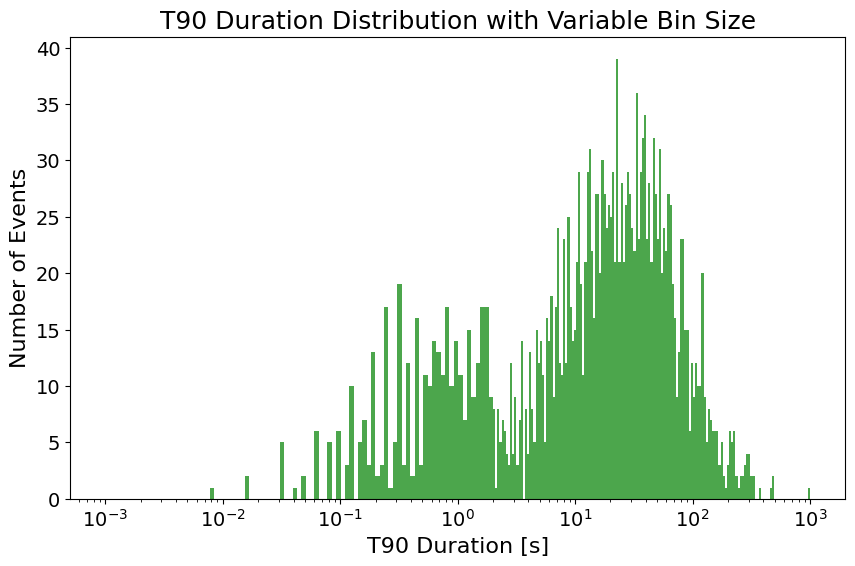

In [3]:
# Extract time data, and plot histograms of time and duration
create_time_data_plots(fermi_data, 'plots')

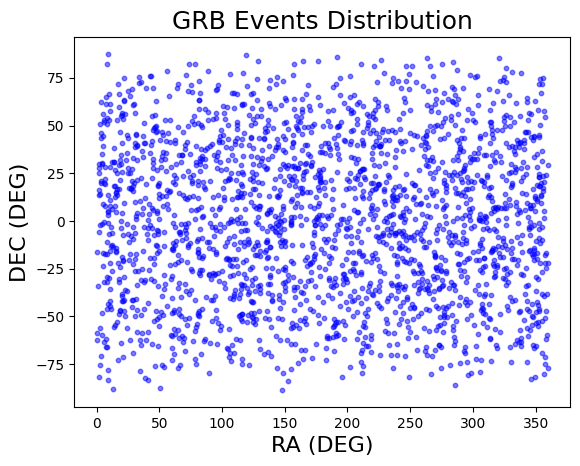

In [4]:
# Extract location data, and plot histograms of location
create_location_data_plots(fermi_data, 'plots')

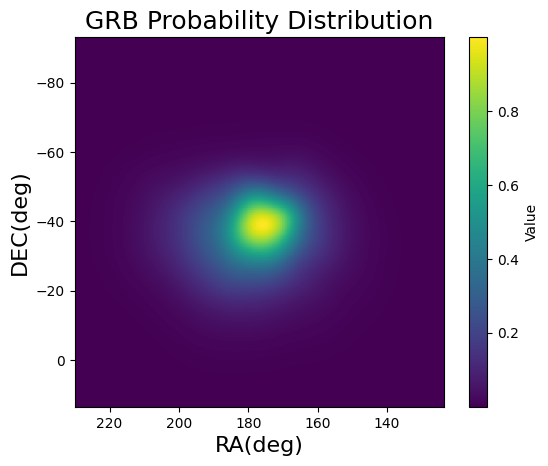

In [6]:
from gw_grb_correlation.Fermi.download_data_functions import download_file
from gw_grb_correlation.Fermi.visualization import plot_certain_event_prob_dist
# Base URL parts
url_locprob = "https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2017/bn170817529/current/glg_locprob_all_bn170817529_v02.fit"
filename_locprob = "glg_locprob_all_bn170817529_v00.fit"

download_file(url_locprob, filename_locprob)
plot_certain_event_prob_dist(filename_locprob, 'plots')

C:\Users\aw106\Desktop\theorywork\group_project_2025\gw_grb_correlation\Fermi\visualization.py:419: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ra, dec, s=100, c=colors(num), alpha=0.5, label=name)


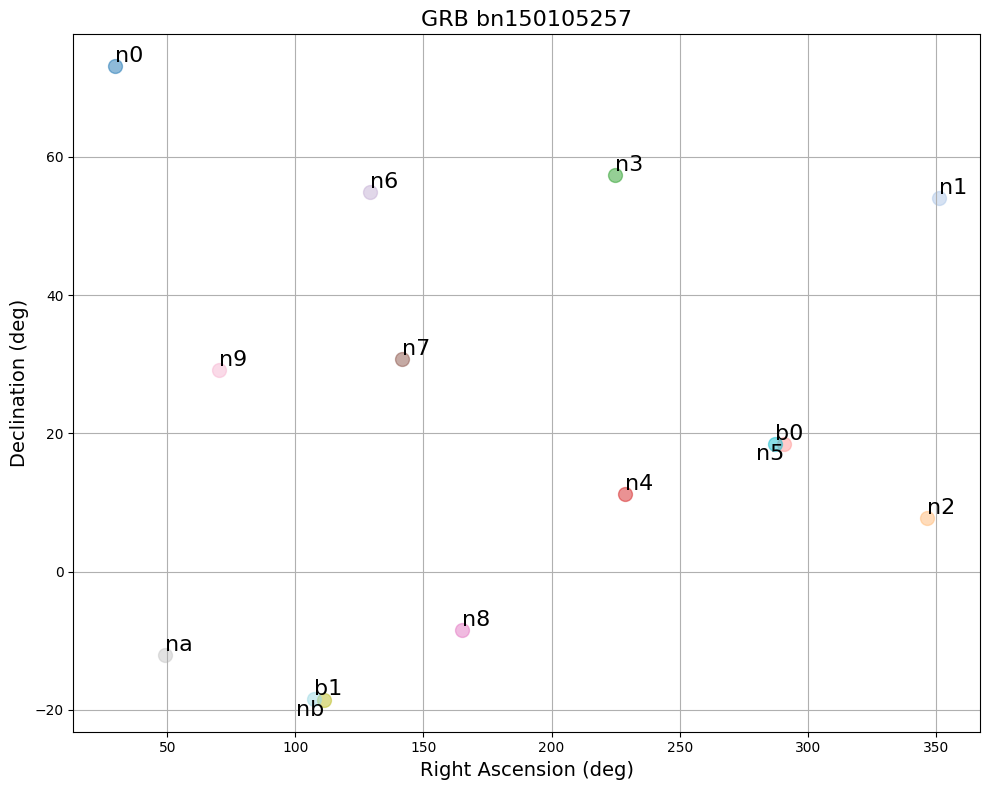

In [7]:
plot_all_detector_positions(fermi_data.head(1), plt_show_or_not=True)

In [8]:
from gw_grb_correlation.Fermi.tte_data import extract_fits_excess_photon_data
from gw_grb_correlation.Fermi.visualization import plot_count_rate
from gw_grb_correlation.Fermi.util import extract_tte_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# List of detectors you want
detectors = ['n1', 'n2', 'n5']

# Base URL parts
url_tte = "https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/bursts/2017/bn170817529/current/"
filename_tte = "glg_tte_{}_bn170817529_v00.fit"

# Loop to download each file
for det in detectors:
    url = url_tte + filename_tte.format(det)
    filename = filename_tte.format(det)
    download_file(url, filename)

# Extracting TTE data
tte_data = extract_tte_data(filename_tte.format('n2'))
time, count_rate = plot_count_rate(tte_data, bins=256, plot_or_not=False)

# Load bcat_data from the specified file (time_data.npy)
file_path = f'./fermi_data/time/time_data.npy'
bcat_data = pd.DataFrame(np.load(file_path, allow_pickle=True))
bcat_data.columns = ['ID', 'TSTART', 'TSTOP', 'T90', 'DATE']

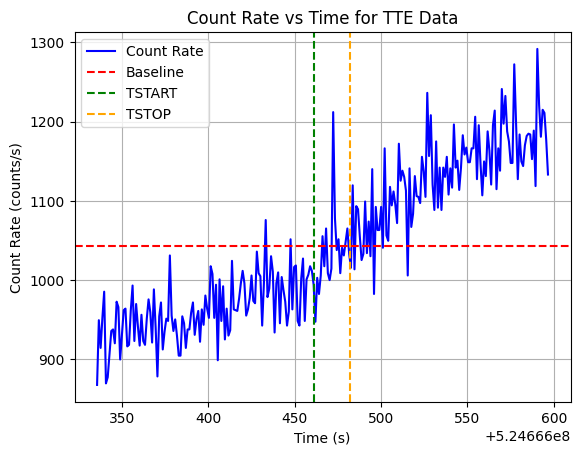

In [9]:
# Assuming time and count_rate are already defined
# Calculate the baseline of the count rate
Baseline = np.average(count_rate)

# Plot the count rate
plt.plot(time, count_rate, label='Count Rate', color='blue')

# Plot the baseline as a horizontal line
plt.axhline(y=Baseline, color='red', linestyle='--', label='Baseline')

# Plot vertical lines for tstart and tstop
GRB_170817A = bcat_data[bcat_data['ID']=='bn170817529']
tstart, tstop = GRB_170817A['TSTART'].values[0], GRB_170817A['TSTOP'].values[0]
plt.axvline(x=tstart, color='green', linestyle='--', label='TSTART')
plt.axvline(x=tstop, color='orange', linestyle='--', label='TSTOP')

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Count Rate (counts/s)')
plt.title('Count Rate vs Time for TTE Data')
plt.legend()
plt.grid()
plt.show()

In [10]:
# Extracting excess photon data
detectors = ['n1', 'n2', 'n5']
for detector in detectors:
    filename = filename_tte.format(detector)
    excess_counts = extract_fits_excess_photon_data(bcat_data, filename, bins=256)
    print(excess_counts[0])  # ID
    print(excess_counts[1])  # Detector
    print(f"Total excess counts for {detector}] = {excess_counts[2]:.2f}")

bn170817529
n1
Total excess counts for n1] = -214.30
bn170817529
n2
Total excess counts for n2] = -116.54
bn170817529
n5
Total excess counts for n5] = -179.47


In [11]:
# Filter out short GRB data
short_GRB_data = filtering(fermi_data, criteria={'T90': lambda x: x <= 2.1})

# Calculate the duration (difference between max TSTOP and min TSTART) and count the short GRB event number
duration_short_GRB = duration(short_GRB_data)
event_num_short_GRB = len(short_GRB_data)

# Calculate the average occurrence rate (events per unit of time)
average_occurrence_rate = event_num_short_GRB / duration_short_GRB

# Print the results
print(f"Number of events: {event_num_short_GRB}")
print(f"Total duration: {duration_short_GRB} seconds")
print(f"Average occurrence rate: {average_occurrence_rate} events per second")

Number of events: 357
Total duration: 323245732.96269 seconds
Average occurrence rate: 1.1044229315200459e-06 events per second


In [13]:
# Load GW data
gw_data = read_GW_data(f"./gw_data/totalgwdata.csv")
gw_times = remove_duplicate_times_in_gw_data(gw_data)

# Find matched GRB-GW event pairs
match = compare_time_within_range(short_GRB_data, gw_times, time_range_seconds=86400*3)
filtered_gw_events = gw_data[gw_data['times'].isin(match['gw_time'])]
match.to_csv("GRB_GW_event_pairs.csv", index=False)
filtered_gw_events.to_csv("Filtered_GW_events.csv", index=False)

Data from ./gw_data/totalgwdata.csv loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418227 entries, 0 to 2418226
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   ra          float64
 2   dec         float64
 3   times       float64
 4   weights     float64
dtypes: float64(4), int64(1)
memory usage: 92.2 MB
None
   Unnamed: 0        ra       dec         times   weights
0           0  1.891867 -1.250744  1.126259e+09  0.000024
1           1  1.254342 -1.228042  1.126259e+09  0.000024
2           2  1.666787 -1.279668  1.126259e+09  0.000024
3           3  1.863250 -1.261367  1.126259e+09  0.000024
4           4  0.994238 -1.036272  1.126259e+09  0.000024
Number of unique times after applying threshold: 91
First few unique times:
               times                          date
0       1.126259e+09 2015-09-14 09:51:02.000000000
44173   1.128679e+09 2015-10-12 09:55:00.000000000
79620   1.135136e+09 20

C:\Users\aw106\Desktop\theorywork\group_project_2025\gw_grb_correlation\Fermi\util.py:216: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = pd.to_numeric(fermi_data['TSTART'], errors='coerce')
C:\Users\aw106\Desktop\theorywork\group_project_2025\gw_grb_correlation\Fermi\util.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fermi_data['ALIGNED_SEC'] = fermi_data['ALIGNED_SEC'] + (fermi_start_date - pd.Timestamp("1980-01-01")).total_seconds()


Found 44 matches within 259200 seconds.
